# Loading in Data from ArcGIS

Below are the datasets that will be loaded via ArcGIS API:

**By Medical Survey Study Area**
1. MSSA DETAIL (2018) - OSHPD (https://oshpd-chhsagency.opendata.arcgis.com/datasets/CHHSAgency::mssa-detail/explore?location=36.917905%2C-118.736174%2C6.18)
2. PRIMARY CARE SHORTAGE AREAS (2018) - MSSA ID (https://data.chhs.ca.gov/dataset/primary-care-shortage-areas-in-california/resource/0ba7c904-2302-400a-ba27-b8e8e5c1ab4a)

**By Hospital**
1. Hospital Mortality Rates (2016-2022) - CHHS (https://data.chhs.ca.gov/dataset/california-hospital-inpatient-mortality-rates-and-quality-ratings/resource/af88090e-b6f5-4f65-a7ea-d613e6569d96)
2. Case Mix Index (CMI) (2018) - CHHS (https://data.chhs.ca.gov/dataset/case-mix-index/resource/5a04e554-8d37-4e81-9d6b-1170045bcc82?inner_span=True)

In [1]:
import glob
import json
import os
import statistics
import urllib.request
from io import StringIO

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from IPython.display import clear_output
from shapely.geometry import LineString, MultiLineString, Point, Polygon
from shapely.ops import nearest_points

In [2]:
def get_max_record_count(query_url):
    """
    Runs a small ping to the layer to retrieve max number of records obtainable per GET request.
    Args:
        query_url (str): String of the layer to pull metadata from
    Returns:
        maxRecordCount (int): Max number of records obtained per GET request
    """
    # validate token
    response = requests.get(query_url)
    max_record_count = response.json().get("maxRecordCount")
    return max_record_count


def pull_and_concatenate_data(max_record_count: int, url: str, query_params=dict):
    """
    Iteratively pulls data from the ArcGIS server to obtain all data
    """
    records_left_bool = True
    gdf_output = None
    record = max_record_count
    while records_left_bool:
        print(record)
        response = requests.get(url, params=query_params)
        if response.json().get("features") == []:
            print("The query results in no rows, please double check your arguments.")
            return None
        data = response.json()
        response = response.text
        gdf = gpd.GeoDataFrame(gpd.read_file(StringIO(response)))

        if isinstance(gdf_output, pd.DataFrame) == False:
            gdf_output = gdf
        else:
            gdf_output = pd.concat([gdf_output, gdf])

        if data.get("properties") != None:
            records_left_bool = data.get("properties")["exceededTransferLimit"]
        else:
            records_left_bool = False

        query_params["resultOffset"] += max_record_count
        record += max_record_count
    return gdf_output

## MSSA

In [3]:
url = "https://services7.arcgis.com/vA61DZby76ncaItU/arcgis/rest/services/MSSA_Detail_2014/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
response = requests.get(url).text
MSSA_areas = gpd.GeoDataFrame(gpd.read_file(StringIO(response)))

query_params = {"resultOffset": 0}
MSSA_areas = pull_and_concatenate_data(
    max_record_count=1000, url=url, query_params=query_params
)
MSSA_areas = MSSA_areas[
    [
        "OBJECTID",
        "TRACT",
        "MSSA_ID",
        "MSSA_NAME",
        "POP",
        "PCT100POV",
        "PCT200POV",
        "geometry",
    ]
]
MSSA_areas = MSSA_areas.to_crs("EPSG:32610")
MSSA_areas.info()
MSSA_areas.head()

1000
2000
3000
4000
5000
6000
7000
8000
9000
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 8036 entries, 0 to 35
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   OBJECTID   8036 non-null   int64   
 1   TRACT      8036 non-null   object  
 2   MSSA_ID    8036 non-null   object  
 3   MSSA_NAME  8036 non-null   object  
 4   POP        8036 non-null   int64   
 5   PCT100POV  8036 non-null   float64 
 6   PCT200POV  8036 non-null   float64 
 7   geometry   8036 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(3)
memory usage: 565.0+ KB


,OBJECTID,TRACT,MSSA_ID,MSSA_NAME,POP,PCT100POV,PCT200POV,geometry
0,1,4427.00,2i,Fremont South/Mission San Jose/Newark South/Wa...,2459,3.3,6.871438,"POLYGON ((587871.524 4155232.504, 587930.425 4..."
1,2,4428.00,2i,Fremont South/Mission San Jose/Newark South/Wa...,2396,11.7,28.021802,"POLYGON ((589854.780 4153982.554, 589842.874 4..."
2,3,2049.20,78.2h,Boyle Heights Central/City Terrace West,103,27.5,62.798902,"POLYGON ((944073.326 3774847.172, 944073.936 3..."
3,4,2051.10,78.2h,Boyle Heights Central/City Terrace West,148,46.4,82.649044,"POLYGON ((942299.798 3775226.643, 942385.192 3..."
4,5,2051.20,78.2h,Boyle Heights Central/City Terrace West,146,38.9,77.784140,"POLYGON ((942555.407 3775104.217, 942570.486 3..."


This data set breaks down each MSSA by _census tract_. I can provide an area based weighted average on poverty rate

In [4]:
MSSA_areas[MSSA_areas["MSSA_ID"] == "78.2h"].explore()

## PCSA

In [5]:
url = "https://data.chhs.ca.gov/api/3/action/datastore_search?resource_id=0ba7c904-2302-400a-ba27-b8e8e5c1ab4a&limit=1000"
fileobj = urllib.request.urlopen(url)
response_dict = json.loads(fileobj.read())
PCSA = pd.DataFrame(response_dict["result"]["records"]).drop(columns="_id")
PCSA.info()
PCSA.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MSSA_COUNTY           542 non-null    object 
 1   MSSA_ID               542 non-null    object 
 2   MSSA_NAME             542 non-null    object 
 3   Total_Population      542 non-null    int64  
 4   EST_Physicians        542 non-null    float64
 5   EST_FNPPA             542 non-null    float64
 6   EST_Providers         542 non-null    float64
 7   Provider_Ratio        512 non-null    float64
 8   Score_Provider_Ratio  542 non-null    int64  
 9   Pop_100FPL            542 non-null    int64  
 10  PCT_100FPL            542 non-null    float64
 11  Score_Poverty         542 non-null    int64  
 12  Score_Total           542 non-null    int64  
 13  PCSA                  542 non-null    object 
 14  Effective Date        542 non-null    object 
dtypes: float64(5), int64(5)

,MSSA_COUNTY,MSSA_ID,MSSA_NAME,Total_Population,EST_Physicians,EST_FNPPA,EST_Providers,Provider_Ratio,Score_Provider_Ratio,Pop_100FPL,PCT_100FPL,Score_Poverty,Score_Total,PCSA,Effective Date
0,Alameda,1.1,Livermore Central and West/Spring Town,58273,46.0,5.0,49.8,1172.5,1,3149,0.054,1,2,No,2020-01-30T00:00:00
1,Alameda,1.2,Altamont/Livermore East/Midway/Mountain House/...,39930,13.5,2.7,15.5,2576.1,4,1774,0.044,0,4,No,2020-01-30T00:00:00
2,Alameda,2a,Berkeley South and West/Emeryville/Oakland Nor...,86595,116.0,78.7,175.0,494.8,0,20908,0.241,4,4,No,2020-01-30T00:00:00
3,Alameda,2b,Albany/Berkeley East and North/Claremont/Cragm...,110451,273.0,39.4,302.6,365.0,0,8701,0.079,1,1,No,2020-01-30T00:00:00
4,Alameda,2c,Oakland West Central,88757,361.0,48.1,397.0,223.6,0,22684,0.256,5,5,Yes,2020-01-30T00:00:00


## Hospital Mortality Rates

- this column includes extra 3 digits to define type of facility

In [6]:
url = "https://data.chhs.ca.gov/api/3/action/datastore_search?resource_id=af88090e-b6f5-4f65-a7ea-d613e6569d96&limit=50000"
fileobj = urllib.request.urlopen(url)
response_dict = json.loads(fileobj.read())
mortalities_1 = pd.DataFrame(response_dict["result"]["records"]).drop(columns="_id")

url = "https://data.chhs.ca.gov/api/3/action/datastore_search?resource_id=af88090e-b6f5-4f65-a7ea-d613e6569d96&limit=50000&offset=50000"
fileobj = urllib.request.urlopen(url)
response_dict = json.loads(fileobj.read())
mortalities_2 = pd.DataFrame(response_dict["result"]["records"]).drop(columns="_id")

In [7]:
mortalities = pd.concat([mortalities_1, mortalities_2])
mortalities["OSHPDID"] = mortalities["OSHPDID"].apply(lambda x: x[3:])
mortalities.replace(".", np.nan, inplace=True)
mortalities.replace("None", np.nan, inplace=True)
mortalities = mortalities.fillna(value=np.nan)

mortalities = mortalities.dropna(subset=["LONGITUDE", "LATITUDE"])

mortalities = gpd.GeoDataFrame(
    mortalities,
    geometry=gpd.points_from_xy(mortalities.LONGITUDE, mortalities.LATITUDE),
    crs="EPSG:4326",
)
mortalities = mortalities.rename(
    columns={"Risk Adjuested Mortality Rate": "Risk Adjusted Mortality Rate"}
)
mortalities.info()
mortalities.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 57222 entries, 16 to 7653
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   YEAR                          57222 non-null  object  
 1   COUNTY                        57222 non-null  object  
 2   HOSPITAL                      57222 non-null  object  
 3   OSHPDID                       57222 non-null  object  
 4   Procedure/Condition           57222 non-null  object  
 5   Risk Adjusted Mortality Rate  35990 non-null  object  
 6   # of Deaths                   36074 non-null  object  
 7   # of Cases                    36074 non-null  object  
 8   Hospital Ratings              36074 non-null  object  
 9   LONGITUDE                     57222 non-null  object  
 10  LATITUDE                      57222 non-null  object  
 11  geometry                      57222 non-null  geometry
dtypes: geometry(1), object(11)
memory usage: 5.

,YEAR,COUNTY,HOSPITAL,OSHPDID,Procedure/Condition,Risk Adjusted Mortality Rate,# of Deaths,# of Cases,Hospital Ratings,LONGITUDE,LATITUDE,geometry
16,2016,Alameda,Alameda Hospital,010735,AAA Repair Unruptured,NaN,NaN,NaN,NaN,-122.253991,37.76266,POINT (-122.25399 37.76266)
17,2016,Alameda,Alameda Hospital,010735,AMI,16.1,3,17,As Expected,-122.253991,37.76266,POINT (-122.25399 37.76266)
18,2016,Alameda,Alameda Hospital,010735,Acute Stroke,23.6,9,74,Worse,-122.253991,37.76266,POINT (-122.25399 37.76266)
19,2016,Alameda,Alameda Hospital,010735,Acute Stroke Hemorrhagic,48.9,5,9,Worse,-122.253991,37.76266,POINT (-122.25399 37.76266)
20,2016,Alameda,Alameda Hospital,010735,Acute Stroke Ischemic,15.2,4,65,As Expected,-122.253991,37.76266,POINT (-122.25399 37.76266)


## CMI

In [8]:
url = "https://data.chhs.ca.gov/api/3/action/datastore_search?resource_id=3ed58730-7dbb-4a48-bae5-0e66929c44f7&limit=6000"
fileobj = urllib.request.urlopen(url)
response_dict = json.loads(fileobj.read())
CMI = pd.DataFrame(response_dict["result"]["records"]).drop(columns="_id")
CMI.rename(columns={"OSHPD_ID": "OSHPDID"}, inplace=True)
CMI = CMI[["COUNTY", "OSHPDID", "HOSPITAL", "FY2018"]]
CMI.info()
CMI.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   COUNTY    637 non-null    object
 1   OSHPDID   637 non-null    object
 2   HOSPITAL  637 non-null    object
 3   FY2018    447 non-null    object
dtypes: object(4)
memory usage: 20.0+ KB


,COUNTY,OSHPDID,HOSPITAL,FY2018
632,VENTURA,564018,LOS ROBLES REGIONAL MEDICAL CENTER - EAST CAMPUS,None
633,VENTURA,564121,"THOUSAND OAKS SURGICAL HOSPITAL, A CAMPUS OF L...",None
634,YOLO,571086,WOODLAND MEMORIAL HOSPITAL,1.3580727322107546
635,YOLO,574010,SUTTER DAVIS HOSPITAL,1.0906520662768036
636,YUBA,580996,ADVENTIST HEALTH AND RIDEOUT,1.3717962548824396


# Combining Datasets

Mergine MSSA_areas with PCSA

In [9]:
PCSA.head()

,MSSA_COUNTY,MSSA_ID,MSSA_NAME,Total_Population,EST_Physicians,EST_FNPPA,EST_Providers,Provider_Ratio,Score_Provider_Ratio,Pop_100FPL,PCT_100FPL,Score_Poverty,Score_Total,PCSA,Effective Date
0,Alameda,1.1,Livermore Central and West/Spring Town,58273,46.0,5.0,49.8,1172.5,1,3149,0.054,1,2,No,2020-01-30T00:00:00
1,Alameda,1.2,Altamont/Livermore East/Midway/Mountain House/...,39930,13.5,2.7,15.5,2576.1,4,1774,0.044,0,4,No,2020-01-30T00:00:00
2,Alameda,2a,Berkeley South and West/Emeryville/Oakland Nor...,86595,116.0,78.7,175.0,494.8,0,20908,0.241,4,4,No,2020-01-30T00:00:00
3,Alameda,2b,Albany/Berkeley East and North/Claremont/Cragm...,110451,273.0,39.4,302.6,365.0,0,8701,0.079,1,1,No,2020-01-30T00:00:00
4,Alameda,2c,Oakland West Central,88757,361.0,48.1,397.0,223.6,0,22684,0.256,5,5,Yes,2020-01-30T00:00:00


In [10]:
mssa_with_pcsa = pd.merge(
    left=MSSA_areas,
    right=PCSA[["MSSA_ID", "Score_Provider_Ratio", "Score_Poverty"]],
    on="MSSA_ID",
)
# invert scores for provider ratio
mssa_with_pcsa["Score_Provider_Ratio"] = mssa_with_pcsa["Score_Provider_Ratio"].apply(
    lambda x: abs(5 - x)
)

mssa_with_pcsa.info()
mssa_with_pcsa.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8036 entries, 0 to 8035
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   OBJECTID              8036 non-null   int64   
 1   TRACT                 8036 non-null   object  
 2   MSSA_ID               8036 non-null   object  
 3   MSSA_NAME             8036 non-null   object  
 4   POP                   8036 non-null   int64   
 5   PCT100POV             8036 non-null   float64 
 6   PCT200POV             8036 non-null   float64 
 7   geometry              8036 non-null   geometry
 8   Score_Provider_Ratio  8036 non-null   int64   
 9   Score_Poverty         8036 non-null   int64   
dtypes: float64(2), geometry(1), int64(4), object(3)
memory usage: 627.9+ KB


,OBJECTID,TRACT,MSSA_ID,MSSA_NAME,POP,PCT100POV,PCT200POV,geometry,Score_Provider_Ratio,Score_Poverty
0,1,4427.00,2i,Fremont South/Mission San Jose/Newark South/Wa...,2459,3.3,6.871438,"POLYGON ((587871.524 4155232.504, 587930.425 4...",1,0
1,2,4428.00,2i,Fremont South/Mission San Jose/Newark South/Wa...,2396,11.7,28.021802,"POLYGON ((589854.780 4153982.554, 589842.874 4...",1,0
2,3,2049.20,78.2h,Boyle Heights Central/City Terrace West,103,27.5,62.798902,"POLYGON ((944073.326 3774847.172, 944073.936 3...",1,5
3,4,2051.10,78.2h,Boyle Heights Central/City Terrace West,148,46.4,82.649044,"POLYGON ((942299.798 3775226.643, 942385.192 3...",1,5
4,5,2051.20,78.2h,Boyle Heights Central/City Terrace West,146,38.9,77.784140,"POLYGON ((942555.407 3775104.217, 942570.486 3...",1,5


Merging mortalities data set with Case Mix Index
- still need to be grouped by hospital for mortality stats

In [11]:
hospitals = pd.merge(left=mortalities, right=CMI, on="OSHPDID")
hospitals = gpd.GeoDataFrame(
    hospitals,
    geometry=gpd.points_from_xy(hospitals.LONGITUDE, hospitals.LATITUDE),
    crs="EPSG:4326",
)
hospitals.info()
hospitals.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 57222 entries, 0 to 57221
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   YEAR                          57222 non-null  object  
 1   COUNTY_x                      57222 non-null  object  
 2   HOSPITAL_x                    57222 non-null  object  
 3   OSHPDID                       57222 non-null  object  
 4   Procedure/Condition           57222 non-null  object  
 5   Risk Adjusted Mortality Rate  35990 non-null  object  
 6   # of Deaths                   36074 non-null  object  
 7   # of Cases                    36074 non-null  object  
 8   Hospital Ratings              36074 non-null  object  
 9   LONGITUDE                     57222 non-null  object  
 10  LATITUDE                      57222 non-null  object  
 11  geometry                      57222 non-null  geometry
 12  COUNTY_y                      57222 no

,YEAR,COUNTY_x,HOSPITAL_x,OSHPDID,Procedure/Condition,Risk Adjusted Mortality Rate,# of Deaths,# of Cases,Hospital Ratings,LONGITUDE,LATITUDE,geometry,COUNTY_y,HOSPITAL_y,FY2018
0,2016,Alameda,Alameda Hospital,010735,AAA Repair Unruptured,NaN,NaN,NaN,NaN,-122.253991,37.76266,POINT (-122.25399 37.76266),ALAMEDA,ALAMEDA HOSPITAL,1.3538540609137057
1,2016,Alameda,Alameda Hospital,010735,AMI,16.1,3,17,As Expected,-122.253991,37.76266,POINT (-122.25399 37.76266),ALAMEDA,ALAMEDA HOSPITAL,1.3538540609137057
2,2016,Alameda,Alameda Hospital,010735,Acute Stroke,23.6,9,74,Worse,-122.253991,37.76266,POINT (-122.25399 37.76266),ALAMEDA,ALAMEDA HOSPITAL,1.3538540609137057
3,2016,Alameda,Alameda Hospital,010735,Acute Stroke Hemorrhagic,48.9,5,9,Worse,-122.253991,37.76266,POINT (-122.25399 37.76266),ALAMEDA,ALAMEDA HOSPITAL,1.3538540609137057
4,2016,Alameda,Alameda Hospital,010735,Acute Stroke Ischemic,15.2,4,65,As Expected,-122.253991,37.76266,POINT (-122.25399 37.76266),ALAMEDA,ALAMEDA HOSPITAL,1.3538540609137057


In [12]:
hospitals["Risk Adjusted Mortality Rate"] = (
    hospitals["Risk Adjusted Mortality Rate"].replace(".", np.nan).astype("float64")
)
hospitals = hospitals.fillna(value=np.nan)
hospitals.FY2018 = hospitals.FY2018.replace("None", np.nan).astype("float64")
hospitals = hospitals.to_crs("EPSG:32610")

In [13]:
mortality_rates = hospitals.groupby("OSHPDID")[["Risk Adjusted Mortality Rate"]].mean()
mortality_rates.rename(columns={"Risk Adjusted Mortality Rate": "RAMR"}, inplace=True)

### Plotting - MSSAs

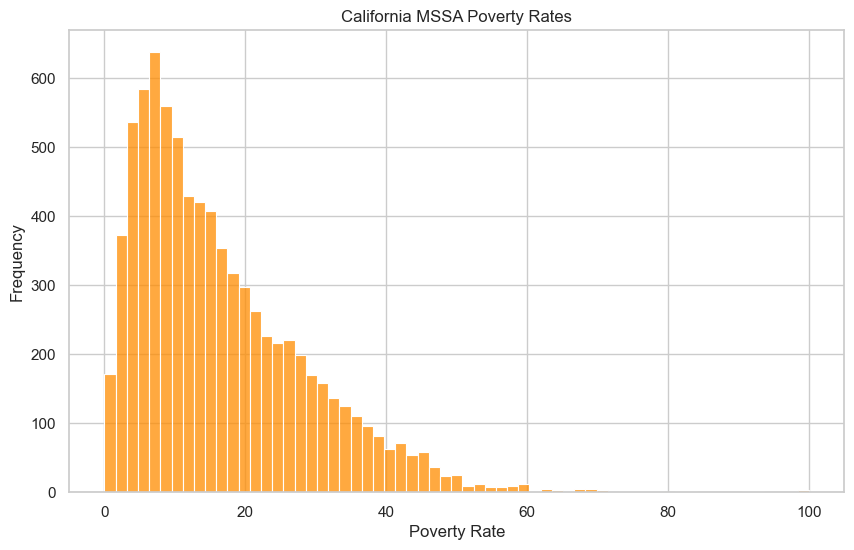

In [14]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", palette="pastel")
sns.histplot(MSSA_areas.PCT100POV, kde=False, color="darkorange")
plt.title("California MSSA Poverty Rates")
plt.xlabel("Poverty Rate")
plt.ylabel("Frequency")

plt.show()

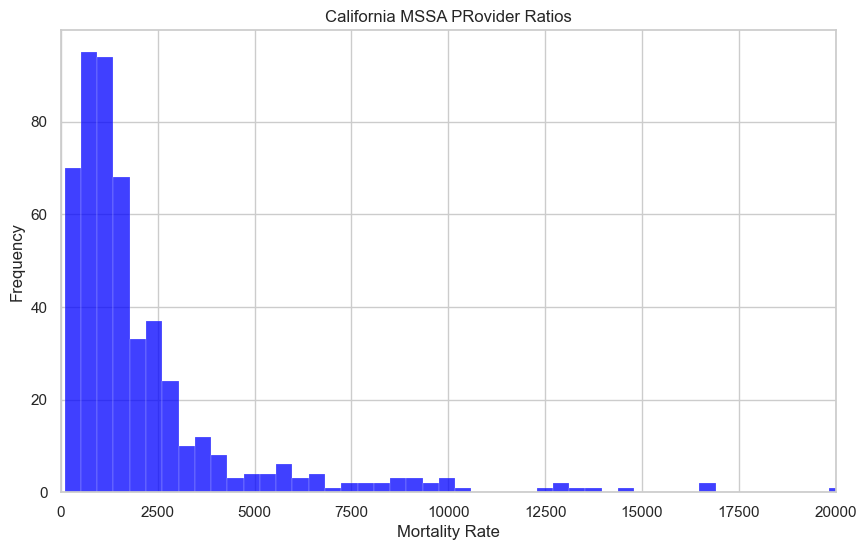

In [15]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", palette="pastel")
sns.histplot(PCSA.Provider_Ratio, kde=False, color="blue")
plt.title("California MSSA PRovider Ratios")
plt.xlim(0, 20000)
plt.xlabel("Mortality Rate")
plt.ylabel("Frequency")

plt.show()

### Plotting - Hospitals

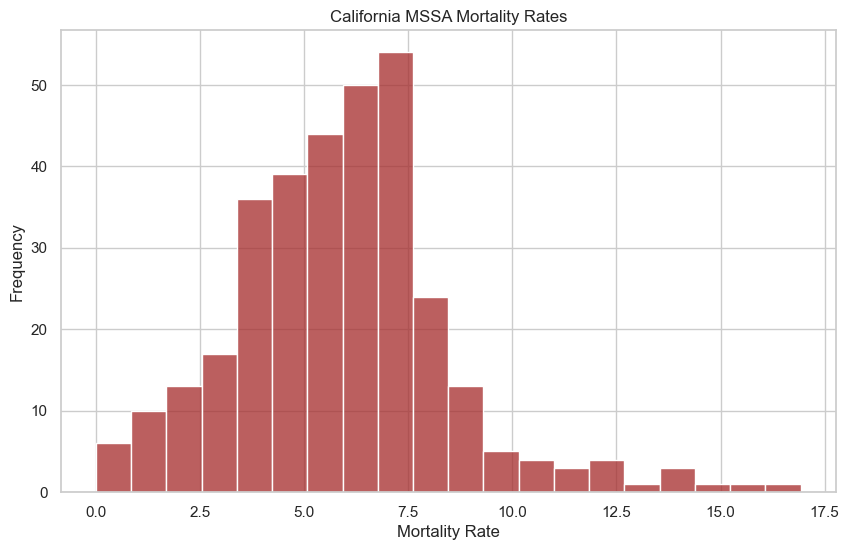

In [16]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", palette="pastel")
sns.histplot(mortality_rates.RAMR, kde=False, color="brown")
plt.title("California MSSA Mortality Rates")
plt.xlabel("Mortality Rate")
plt.ylabel("Frequency")

plt.show()

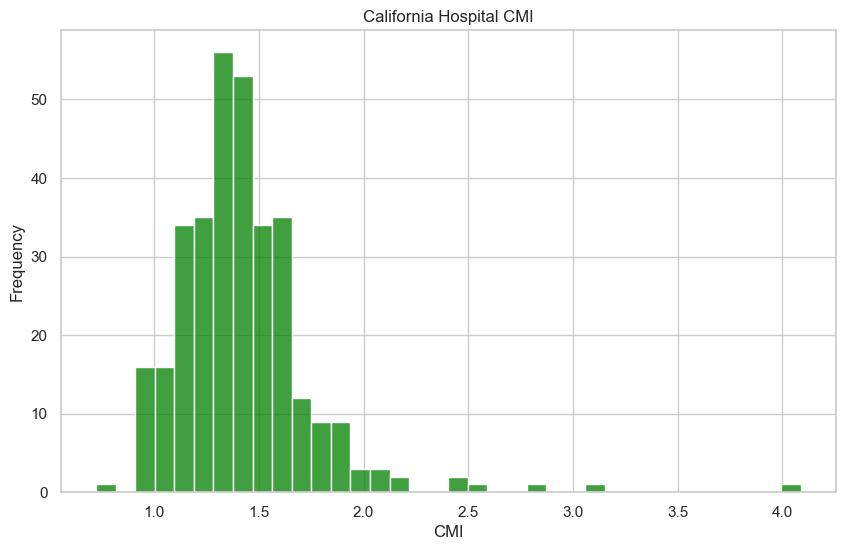

In [17]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", palette="pastel")
sns.histplot(hospitals.FY2018.unique(), kde=False, color="green")
plt.title("California Hospital CMI")
plt.xlabel("CMI")
plt.ylabel("Frequency")

plt.show()

# Determining Parameter Bins

These bins are created based on percentiles, with 4 breakpoint values, we will have scores ranging from 1-5.
- Shortage rates have already been given a rating

In [18]:
def calculate_percentile_bins(
    df, column=None, percentiles=[0.50, 0.75, 0.90, 0.95, 0.99]
):
    """
    Calculates various percentiles and returns in format of dataframe.
    """
    values = []
    for i in percentiles:
        if column:
            values.append(df[column].quantile(i).round(3))
        else:
            values.append(df.quantile(i).values[0].round(3))

    return values

In [19]:
# CMI Scores
calculate_percentile_bins(hospitals, "FY2018")

[1.379, 1.558, 1.737, 1.922, 2.54]

In [20]:
calculate_percentile_bins(hospitals, "FY2018", percentiles = [0.10, 0.25, 0.5, 0.7, 0.9])

[1.102, 1.229, 1.379, 1.509, 1.737]

I want to invert the scale of the CMI bins. The higher the bin, the lower the score.

In [21]:
# Mortality Rates
calculate_percentile_bins(mortality_rates)

[5.915, 7.193, 8.509, 10.204, 14.368]

# Score Calculation

Main components:
MSSA Centric
- Weighted poverty
- Patient to Provider Ratio

Hospital Centric (Weighted by distance)
- CMI
- Mortality

07/22
There are a lot of MSSAs (over half) that do not have a hospital in them. This is due to rural areas, or just due to the nature in which MSSAs are selected. Here are alternatives to contribute the original intended factors into the score:


- I want to first get the MSSA IDs, and then for each ID I want to get total MSSA area (group together tracts) and assign each tract a "weight" based on proportion of total MSSA
- use weight to get representative mortality rate

#### Loading in Parameters

In [22]:
# Read JSON data from file
with open("mssa_scoring_params.json", "r") as file:
    data = json.load(file)
# Extract bins and sort bins by the start of the range
bins = data["range_multiplier_bins"]
range_mult_bins = sorted(bins, key=lambda x: x["range_km"][0])

bins = data["poverty_bins"]
poverty_bins = sorted(bins, key=lambda x: x["pov_rate"][0])

bins = data["CMI_bins"]
cmi_bins = sorted(bins, key=lambda x: x["CMI_value"][0])

bins = data["mortality_bins"]
mortality_bins = sorted(bins, key=lambda x: x["mortality_rate"][0])

#### Scoring Functions

In [68]:
def find_and_calculate_hospital_scores(mssa_id, mask, hospitals_gdf, num_hospitals=1, target_hospitals = None):
    hospitals_gdf = hospitals_gdf.copy()
    num_hospitals = num_hospitals
    score_df = None
    
    hospital_scores = []

    if isinstance(target_hospitals, pd.DataFrame):
        print("FIRST CALCULATING INSIDE SCORES")
        for i in target_hospitals.OSHPDID.unique():
            print("OSHPDID:", i)
            row = target_hospitals.loc[target_hospitals.OSHPDID == i]
            score_output_df = calculate_hospital_score(
                row,
                distance = 1,
                distance_multi_mapping=range_mult_bins,
                mortality_mapping=mortality_bins,
                cmi_mapping=cmi_bins,
            )

            if isinstance(score_df, pd.DataFrame):
                score_df = pd.concat([score_df, score_output_df])
            else:
                score_df = score_output_df

            hospitals_gdf = hospitals_gdf[~hospitals_gdf.isin(row)].dropna()

    if num_hospitals > 0:
        print("SEARCHING FOR HOSPITALS")
        
        for i in range(0, num_hospitals):
            nearest_geom = nearest_points(mask, hospitals_gdf.unary_union)[1]
            nearest_row = hospitals_gdf.loc[hospitals_gdf.geometry == nearest_geom]
    
            # update remaining hospitals
            hospitals_gdf = hospitals_gdf[~hospitals_gdf.isin(nearest_row)].dropna()
    
            # isolate object and calculate distance in km
            target_obj = nearest_row.geometry.iloc[0]
            distance = mask.distance(target_obj) / 1000
    
            score_output_df = calculate_hospital_score(
                nearest_row,
                distance,
                distance_multi_mapping=range_mult_bins,
                mortality_mapping=mortality_bins,
                cmi_mapping=cmi_bins,
            )
    
            if isinstance(score_df, pd.DataFrame):
                score_df = pd.concat([score_df, score_output_df])
            else:
                score_df = score_output_df
    
            num_hospitals += 1

    # save output df as json
    score_df = score_df.reset_index(drop=True)
    score_df = gpd.GeoDataFrame(score_df, crs ='EPSG:32610')
    score_df.to_file(f"output_mssa_scores/{mssa_id}.geojson", driver = 'GeoJSON')
    return score_df

In [69]:
def calculate_hospital_score(
    hospital_df, distance, distance_multi_mapping, mortality_mapping, cmi_mapping
):
    """
    Calculates scores from a hospital's data, returning a dictionary including the score and relevant components.
    """
    avg_mortality_rate = float(hospital_df["Risk Adjusted Mortality Rate"].mean())
    cmi = float(hospital_df["FY2018"].iloc[0])  # case mix index
    # distance multiplier
    for bin in distance_multi_mapping:
        if bin["range_km"][0] <= distance < bin["range_km"][1]:
            distance_multiplier = bin["multiplier"]
    # poverty score
    for bin in mortality_mapping:
        if bin["mortality_rate"][0] <= avg_mortality_rate < bin["mortality_rate"][1]:
            mortality_score = bin["value"]
    # cmi score
    for bin in cmi_mapping:
        if bin["CMI_value"][0] <= cmi < bin["CMI_value"][1]:
            cmi_score = bin["value"]

    if np.isnan(cmi):
        print("AUTOFILL")
        cmi_score = 2
        pass
    else:
        print("VALID")

    score = distance_multiplier * (mortality_score + cmi_score)

    # format output into dataframe
    output_df = pd.DataFrame(
        data={
            "OSHPDID": [hospital_df["OSHPDID"].iloc[0]],
            "HOSPITAL": [hospital_df["HOSPITAL_x"].iloc[0]],
            "SCORE": [score],
            "DIST_MULT": [distance_multiplier],
            "MORT_RATE_SCORE": [mortality_score],
            "CMI_SCORE": [cmi_score],
            "geometry": [hospital_df["geometry"].iloc[0]]
        }
    )
    return output_df

## Cleaning Output Directories

In [70]:
def remove_output():
    num_files = len(glob.glob("output_mssa_scores/*.json"))
    for file in glob.glob("output_mssa_scores/*.json"):
        os.remove(file)
    print(f"Successfully deleted {num_files} files.")

## Scoring MSSAs

In [71]:
MSSA_ids = list(MSSA_areas.MSSA_ID.unique())
len(MSSA_ids)

MSSA_ids = MSSA_ids

In [72]:
%%time

remove_output()

empty_mssas = []
num_hospitals = []
mssa_scores = []
single_hospital_mssas = []

scores_table = None
for mssa_id in MSSA_ids:
    clear_output(wait=True)
    print(mssa_id)

    ### MSSA COMPONENT
    # Select MSSA tracts & get ratio
    MSSA_tracts = mssa_with_pcsa.query(f'MSSA_ID == "{mssa_id}"').copy()

    # Calculate area in square kilometers
    print("Calculate area in square kilometers")
    MSSA_tracts["area_sq_km"] = MSSA_tracts.area / 1e6
    MSSA_tracts["area_proportion"] = (
        MSSA_tracts["area_sq_km"] / MSSA_tracts["area_sq_km"].sum()
    )

    # Calculate area-weighted poverty rate
    print("Calculate area-weighted poverty rate and patient-provider ratio")
    provider_patient_ratio_weighted_factor = sum(
        MSSA_tracts["Score_Provider_Ratio"] * MSSA_tracts["area_proportion"]
    )
    PCT100POV_weighted_factor = sum(
        MSSA_tracts["Score_Poverty"] * MSSA_tracts["area_proportion"]
    )

    ### HOSPITAL COMPONENT
    # Create mask for MSSA tracts
    print("masking...")
    mask = MSSA_tracts.unary_union

    # Find hospitals within the MSSA area
    target_hospitals = hospitals[hospitals.geometry.within(mask)]

    #TODO: incorporate if/else statement to calculate the co
    if target_hospitals.OSHPDID.nunique() == 0:
        print("NO HOSPITALS IN MSSA")
        empty_mssas.append(mssa_id)
        num_hospitals.append(0)

        # autofill 2 hospitals
        hospital_score = find_and_calculate_hospital_scores(
            mssa_id, mask, hospitals_gdf=hospitals, num_hospitals=2
        )
    elif target_hospitals.OSHPDID.nunique() == 1:
        print('FOUND ONE HOSPITAL, FINDING SECOND NEAREST ONE')
        single_hospital_mssas.append(mssa_id)
        hospital_score = find_and_calculate_hospital_scores(
            mssa_id, mask, hospitals_gdf=hospitals, num_hospitals=1, target_hospitals = target_hospitals
        )
    else:
        print(f"{target_hospitals.OSHPDID.nunique()} HOSPITALS IN MSSA")
        num_hospitals.append(target_hospitals.HOSPITAL_x.nunique())
        hospital_score = find_and_calculate_hospital_scores(
            mssa_id, mask, hospitals_gdf=hospitals, num_hospitals=0, target_hospitals = target_hospitals
        )
        
    mssa_score = (
        provider_patient_ratio_weighted_factor + PCT100POV_weighted_factor
    ) + hospital_score.SCORE.mean()
    mssa_scores.append(mssa_score)

    score_output_df = pd.DataFrame(
        data={
            "MSSA_ID": [mssa_id],
            "SCORE": [round(mssa_score, 3)],
            "geometry": [mask],
            "hospital_component": [hospital_score.SCORE.mean()],
            "provider_ratio_component": [round(provider_patient_ratio_weighted_factor, 3)],
            "poverty_component": [round(PCT100POV_weighted_factor, 3)],
        }
    )
    if isinstance(scores_table, pd.DataFrame):
        scores_table = pd.concat([scores_table, score_output_df])
    else:
        scores_table = score_output_df
# print("MSSAs without hospitals:", empty_mssas)

28
Calculate area in square kilometers
Calculate area-weighted poverty rate and patient-provider ratio
masking...
NO HOSPITALS IN MSSA
SEARCHING FOR HOSPITALS
VALID
VALID
CPU times: user 2min 41s, sys: 5.34 s, total: 2min 47s
Wall time: 2min 53s


In [73]:
scores_table.to_csv("MSSA_scores.csv", index=False)

In [74]:
final_scores = gpd.GeoDataFrame(scores_table, crs="EPSG:32610")

In [75]:
final_scores.to_file('MSSA_scores.gpkg', layer = 'scores', driver = 'GPKG')

In [76]:
final_scores.head()

,MSSA_ID,SCORE,geometry,hospital_component,provider_ratio_component,poverty_component
0,2i,6.250,"MULTIPOLYGON (((596891.857 4146959.777, 596890...",5.250000,1.0,0.0
0,78.2h,10.500,"POLYGON ((943117.251 3774099.229, 943097.915 3...",4.500000,1.0,5.0
0,78.2ff,12.000,"POLYGON ((940819.280 3779867.139, 940792.227 3...",3.000000,5.0,4.0
0,78.2ffff,12.143,"POLYGON ((937660.196 3775598.751, 937638.671 3...",2.142857,5.0,5.0
0,78.2mmm,9.500,"POLYGON ((939016.709 3769541.718, 938982.738 3...",4.500000,0.0,5.0


# Post Score Calculation Graphics

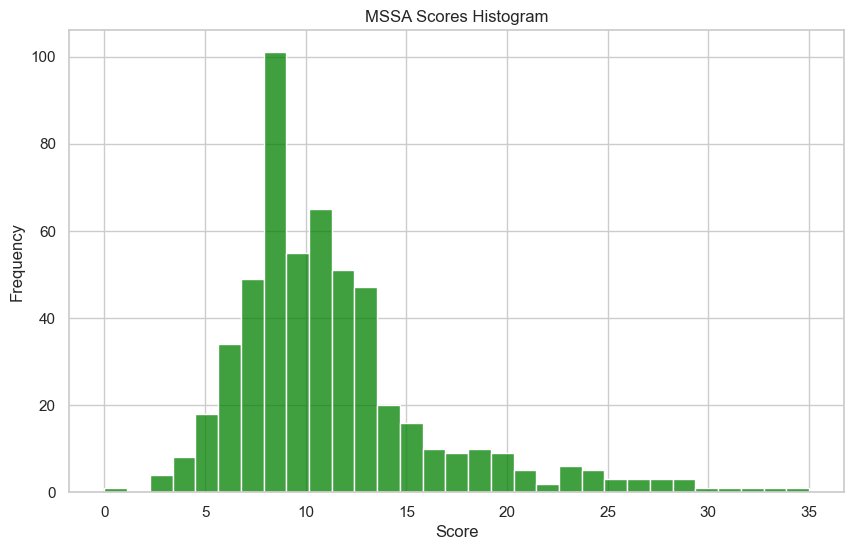

In [77]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", palette="pastel")
sns.histplot(scores_table.SCORE, kde=False, color="green")
plt.title("MSSA Scores Histogram")
plt.xlabel("Score")
plt.ylabel("Frequency")

plt.show()

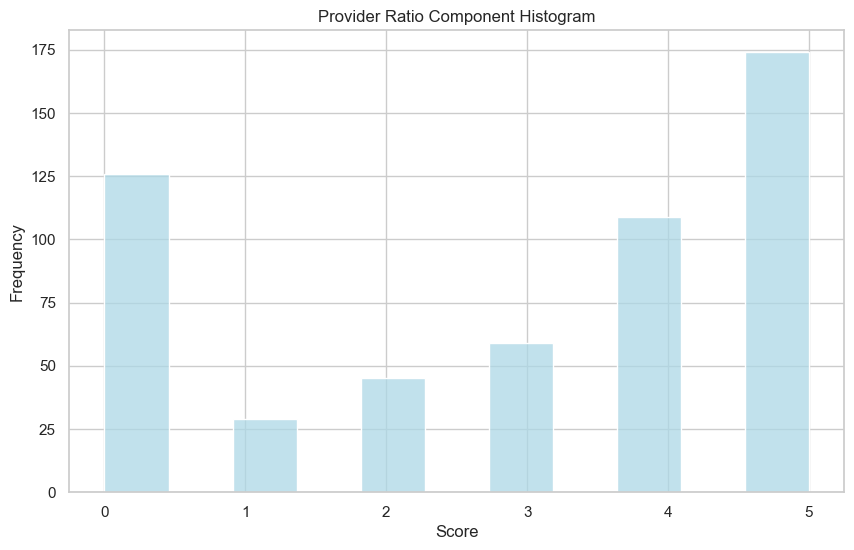

In [78]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", palette="pastel")
sns.histplot(scores_table.provider_ratio_component, kde=False, color="lightblue")
plt.title("Provider Ratio Component Histogram")
plt.xlabel("Score")
plt.ylabel("Frequency")

plt.show()

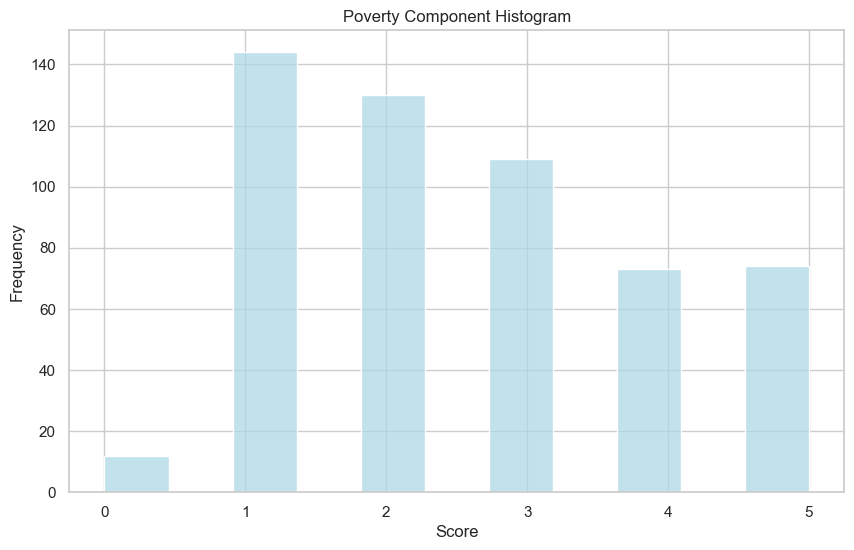

In [79]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", palette="pastel")
sns.histplot(scores_table.poverty_component, kde=False, color="lightblue")
plt.title("Poverty Component Histogram")
plt.xlabel("Score")
plt.ylabel("Frequency")

plt.show()

# Highest Priority Score

In [82]:
MSSA_areas.query('MSSA_ID == "46"').explore()